# Normalisation of samples per patient.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
#from bbknn import bbknn
import matplotlib.pyplot as plt
import scipy as sp

from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import rpy2.rinterface_lib.callbacks
import logging
import anndata2ri


plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

# Work with R
from rpy2.robjects import pandas2ri
# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.2.0
anndata             0.7.6
anndata2ri          1.0.6
backcall            0.2.0
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.2
google              NA
h5py                2.10.0
igraph              0.9.1
ipykernel           5.5.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.4
llvmlite            0.36.0
louvain             0.7.0
markupsafe          1.1.1
matplotlib          3.4.1
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.1
numexpr             2.7.3
numpy               1.20.2
packaging           20.9
pandas              1.2.4
parso               0.8.2
pexpect             4.8.0
pickleshare         0.7.5
pkg_

## Concatenate
In R to follow with scran normalization.

In [2]:
dg=sc.read_h5ad('/data/cellrangerDatasets/Patient_Dg_cr.h5ad')
mrd=sc.read_h5ad('/data/cellrangerDatasets/Patient_MRD_cr.h5ad')
r=sc.read_h5ad('/data/cellrangerDatasets/Patient_R_cr.h5ad')

adata=dg.concatenate(mrd, r, join = 'outer', batch_categories=['Patient_Dg', 'Patient_MRD', 'Patient_R'])
adata

adata.write("/data/cellrangerDatasets/Patient_cr.h5ad")

In [ ]:
%%R
#Load all the R libraries we will be using in the notebook
library(dplyr)
library(Seurat)
library(SeuratDisk)
library(patchwork)
library(ggplot2)
library(loomR)
library(scater)
library(cowplot)
library(anndata)

## Normalisation
Using normalisation function from scran that gives different clusters different size factors.

In [4]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:27)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
running Leiden clustering
    finished: found 15 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:02)


In [5]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']

Scran was updated since https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb was performed. It does not accept matrix anymore, instead it requires a singlecellexperiment object with an assay called counts. 

In [6]:
%%R -i adata -i input_groups
counts <- assay(adata, "X")
counts(adata) <- counts
adata

class: SingleCellExperiment 
dim: 36601 18721 
metadata(0):
assays(2): X counts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(2): gene_ids feature_types
colnames(18721): AAACCCAAGTTCATCG-1-40389_Dg
  AAACCCACACATCATG-1-40389_Dg ... TTTGTTGTCCTATTGT-1-40389_R
  TTTGTTGTCCTCTGCA-1-40389_R
colData names(4): n_counts n_genes percent_mito batch
reducedDimNames(0):
altExpNames(0):


In [7]:
%%R -o adata
library(scran)
adata = computeSumFactors(adata, clusters=input_groups, min.mean=0.1)

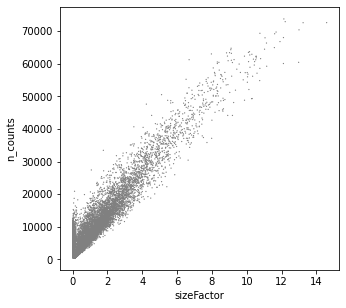

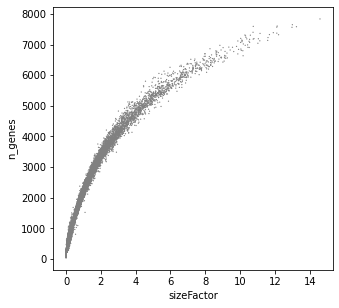

/home/ajordano/software/anaconda3/envs/env1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


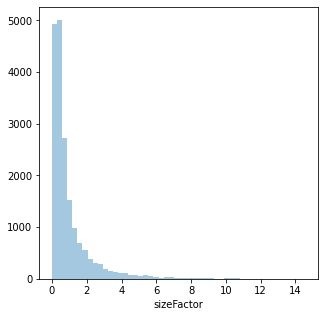

In [9]:
# Visualize the estimated size factors
sc.pl.scatter(adata, 'sizeFactor', 'n_counts')
sc.pl.scatter(adata, 'sizeFactor', 'n_genes')

sb.distplot(adata.obs['sizeFactor'], bins=50, kde=False)
plt.show()

In [10]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 18721 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch', 'sizeFactor'
    var: 'gene_ids', 'feature_types'
    layers: 'counts'

In [11]:
#Normalize adata 
adata.X /= adata.obs['sizeFactor'].values[:,None]
adata.X = sp.sparse.csr_matrix(adata.X) # this step is necessary to infer HVG.
sc.pp.log1p(adata)

In [12]:
#Store the full data set in 'raw'as log-normalised data for statistical testing.
adata.raw = adata
adata.layers["logcounts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 18721 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch', 'sizeFactor'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'
    layers: 'counts', 'logcounts', 'RNA'

In [13]:
adata.obs['n_genes'].dtype

Int32Dtype()

In [14]:
adata.obs['n_genes'] = adata.obs['n_genes'].astype('float64')

In [15]:
adata.write("/data/processingDatasets/Patient_Norm.h5ad")